## References

Quote Mid Price = Spot Price + Basis + Skew  
https://blog.bitmex.com/how-to-market-make-bitcoin-derivatives-lesson-2/  
https://www.bitmex.com/app/fairPriceMarking  
https://www.bitmex.com/app/perpetualContractsGuide  
https://github.com/BitMEX/sample-market-maker  

BuyPrice = Mid-Market + A x Forecast – B x MCR – Current half-spread  
SellPrice = Mid-Market + A x Forecast – B x MCR + Current half-spread  
**https://ieor.columbia.edu/files/seasdepts/industrial-engineering-operations-research/pdf-files/Borden_D_FESeminar_Sp10.pdf ****  

https://www.reddit.com/r/algotrading/comments/6q8dp6/market_making_theory_and_application_readings/

## Implementation
https://github.com/nkaz001/sample-market-maker

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from numba import njit

In [2]:
last_price = pd.read_csv("last_price.csv", index_col='timestamp', converters={'timestamp': pd.to_datetime})
ohlc = last_price.resample('5s', label='right').ohlc().ffill()

In [3]:
fair_basis = pd.read_csv("fair_basis.csv", index_col='timestamp', converters={'timestamp': pd.to_datetime})
fair_basis_ = fair_basis.resample('5s', label='right').ffill()

In [4]:
df = ohlc.merge(fair_basis_, left_on='timestamp', right_on='timestamp', how='outer')
df["fairBasis"] = df["fairBasis"].ffill()
df.columns = ['open', 'high', 'low', 'close', 'fairBasis']

/home/kaz/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [5]:
df

,open,high,low,close,fairBasis
timestamp,,,,,
2020-12-07 00:00:05+00:00,19393.5,19401.0,19393.5,19401.0,NaN
2020-12-07 00:00:10+00:00,19400.5,19409.0,19400.5,19408.5,NaN
2020-12-07 00:00:15+00:00,19409.0,19412.0,19408.5,19411.5,NaN
2020-12-07 00:00:20+00:00,19412.0,19424.5,19411.5,19424.5,NaN
2020-12-07 00:00:25+00:00,19424.0,19432.0,19424.0,19431.5,NaN
...,...,...,...,...,...
2020-12-27 23:59:40+00:00,26230.0,26240.5,26230.0,26240.0,12.26
2020-12-27 23:59:45+00:00,26240.5,26248.5,26240.5,26248.5,12.26
2020-12-27 23:59:50+00:00,26248.0,26248.0,26248.0,26248.0,12.26


In [6]:
@njit
def predict_njit(start_equity, A, B, half_spread, max_position, X):
    tick_size = 0.5
    running_qty = 0
    static_equity = start_equity
    fee = 0
    equity = []
    running_qty_ = []
    order_qty = 100
    new_bid = np.nan
    new_ask = np.nan
    high = 1
    low = 2
    close = 3
    fair_basis = 4
    for row in X:
        if new_bid > row[low]:
            running_qty += order_qty
            static_equity += order_qty / new_bid
            fee += order_qty / new_bid * -0.00025    
        if new_ask < row[high]:
            running_qty -= order_qty
            static_equity -= order_qty / new_ask
            fee += order_qty / new_ask * -0.00025    
        equity.append(static_equity - running_qty / row[close] - fee)
        running_qty_.append(running_qty)
        skew = B * running_qty / max_position * -1
        quote_mid_price = row[close] + A * row[fair_basis] + skew
        new_bid = np.minimum(np.round(quote_mid_price * (1 - half_spread) / tick_size) * tick_size, row[close] - tick_size)
        new_ask = np.maximum(np.round(quote_mid_price * (1 + half_spread) / tick_size) * tick_size, row[close] + tick_size)
        if running_qty > max_position:
            new_bid = np.nan
        if running_qty < -max_position:
            new_ask = np.nan
    return equity, running_qty_

class Backtest:
    def __init__(self, equity=None, max_position=None, A=None, B=None, half_spread=None):
        self.equity = equity
        self.max_position = max_position
        self.A = A
        self.B = B
        self.half_spread = half_spread
        
    def set_params(self, A, B, half_spread):
        self.A = A
        self.B = B
        self.half_spread = half_spread
        return self
        
    def get_params(self, deep=True):
        return { 'equity': self.equity, 'max_position': self.max_position, 'A': self.A, 'B': self.B, 'half_spread': self.half_spread }
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
#         #orders = []
#         tick_size = 0.5
#         running_qty = 0
#         static_equity = self.equity
#         fee = 0
#         equity = []
#         order_qty = 100
#         new_bid = np.nan
#         new_ask = np.nan
#         for _, row in X.iterrows():
#             #for price, qty in orders:
#             #    if qty > 0 and price >= row['low']:
#             #        running_qty += qty
#             #        static_equity -= qty / price
#             #        fee += qty / price * -0.00025    
#             #    if qty < 0 and price <= row['high']:
#             #        running_qty -= qty
#             #        static_equity += qty / price
#             #        fee += qty / price * -0.00025    
#             if new_bid > row['low']:
#                 running_qty += order_qty
#                 static_equity += order_qty / new_bid
#                 fee += order_qty / new_bid * -0.00025    
#             if new_ask < row['high']:
#                 running_qty -= order_qty
#                 static_equity -= order_qty / new_ask
#                 fee += order_qty / new_ask * -0.00025    
#             equity.append(static_equity - running_qty / row['close'] - fee)
#             skew = self.B * running_qty / self.max_position * -1
#             quote_mid_price = row['close'] + self.A * row['fairBasis'] + skew
#             new_bid = np.minimum(np.round(quote_mid_price * (1 - self.half_spread) / tick_size) * tick_size, row['close'] - tick_size)
#             new_ask = np.maximum(np.round(quote_mid_price * (1 + self.half_spread) / tick_size) * tick_size, row['close'] + tick_size)
#             #if running_qty < self.max_position:
#             #    orders.append((new_bid, 100))
#             #if running_qty > -self.max_position:
#             #    orders.append((new_ask, -100))
#             if running_qty > self.max_position:
#                 new_bid = np.nan
#             if running_qty < -self.max_position:
#                 new_ask = np.nan
        equity, running_qty = predict_njit(self.equity, self.A, self.B, self.half_spread, self.max_position, X)
        return equity, running_qty
    
    def score(self, X):
        equity, _ = self.predict(X)
        returns = pd.Series(equity).pct_change().fillna(0)
        bm_returns = pd.Series(X[:, 3]).pct_change().fillna(0)
        returns_ = returns - bm_returns
        
        return np.divide(returns_.mean(), returns_.std())

In [7]:
train = df[df.index < '2020-12-20']
test = df[df.index >= '2020-12-20']

In [8]:
#parameters = { 'A': np.linspace(0.01, 1, 100), 'B': np.linspace(0.01, 1, 100), 'half_spread': np.linspace(0.001, 0.01, 10) }
#search = GridSearchCV(Backtest(10000, 10000), parameters)
#search.fit(df)

param_dist = { 'A': stats.uniform(0, 1), 'B': stats.uniform(0, 1), 'half_spread': stats.uniform(0, 0.01) }
search = RandomizedSearchCV(Backtest(1, 10000),
                            cv=[(np.arange(len(train)), np.arange(len(train)))],
                            param_distributions=param_dist,
                            verbose=1,
                            n_iter=1000,
                            n_jobs=4)
search.fit(train.values)

Fitting 1 folds for each of 1000 candidates, totalling 1000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done 1000 out of 1000 | elapsed:   29.8s finished


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 224636, 224637, 224638]),
                        array([     0,      1,      2, ..., 224636, 224637, 224638]))],
                   estimator=<__main__.Backtest object at 0x7f27c61fd490>,
                   n_iter=1000, n_jobs=4,
                   param_distributions={'A': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f27c61fd310>,
                                        'B': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f27c61fdac0>,
                                        'half_spread': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f27c61fd9d0>},
                   verbose=1)

In [9]:
search.best_params_

{'A': 0.9269134272590446,
 'B': 0.10906799359583841,
 'half_spread': 0.0009927335613013465}

In [10]:
search.best_estimator_.score(train.values)

-0.0029795439030710384

In [11]:
equity, running_qty = search.best_estimator_.predict(train.values)
equity = pd.Series(equity, index=train.index)
running_qty = pd.Series(running_qty, index=train.index)

<AxesSubplot:xlabel='timestamp'>

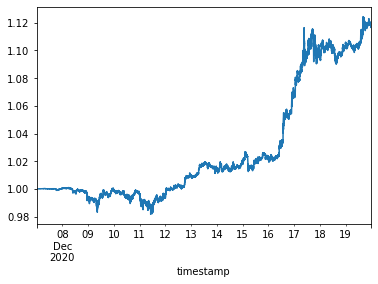

In [12]:
equity.plot()

<AxesSubplot:xlabel='timestamp'>

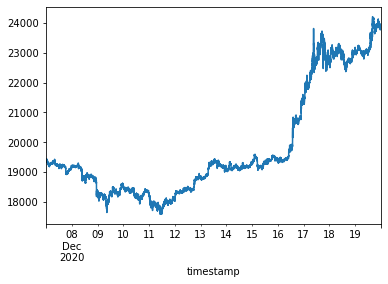

In [13]:
train["close"].plot()

<AxesSubplot:xlabel='timestamp'>

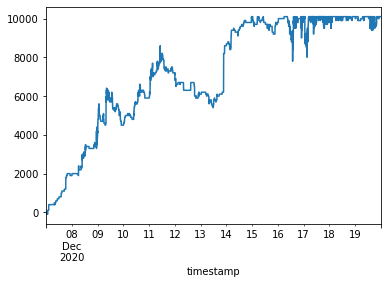

In [14]:
running_qty.plot()

Start date            2020-12-07
End date              2020-12-19
Time period (days)            12
Sharpe Ratio            -6.13685
CAGR                     29.0997
Max Daily Drawdown     0.0425891
dtype: object


<AxesSubplot:>

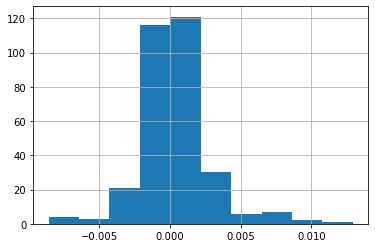

In [15]:
returns = equity.resample('1d').last().pct_change() 
bm_returns = train['close'].resample('1d').last().pct_change()
returns_ = returns - bm_returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(252)

Roll_Max = equity.resample('1d').last().cummax()
Daily_Drawdown = np.divide(equity, Roll_Max) - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Sharpe Ratio': sr,
    'CAGR': (equity[-1] / equity[0]) ** (365 / period) - 1,
    'Max Daily Drawdown': -Max_Daily_Drawdown.min(),
}))

equity.resample('1h').last().pct_change().hist()

In [16]:
equity, running_qty = search.best_estimator_.predict(test.values)
equity = pd.Series(equity, index=test.index)
running_qty = pd.Series(running_qty, index=test.index)

<AxesSubplot:xlabel='timestamp'>

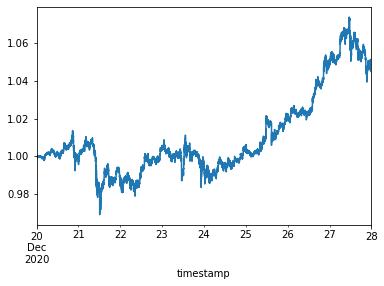

In [17]:
equity.plot()

<AxesSubplot:xlabel='timestamp'>

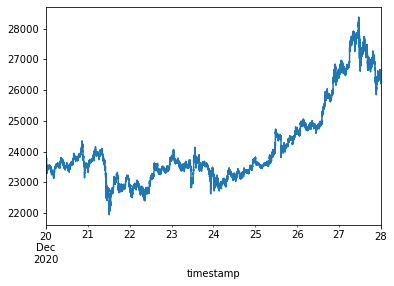

In [18]:
test["close"].plot()

<AxesSubplot:xlabel='timestamp'>

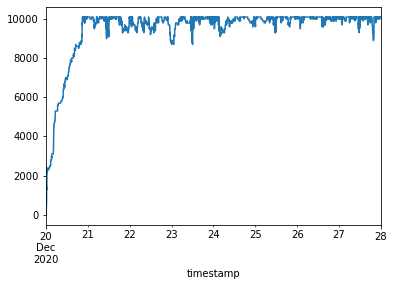

In [19]:
running_qty.plot()

Start date            2020-12-20
End date              2020-12-28
Time period (days)             8
Sharpe Ratio            -6.24244
CAGR                     6.58108
Max Daily Drawdown     0.0256867
dtype: object


<AxesSubplot:>

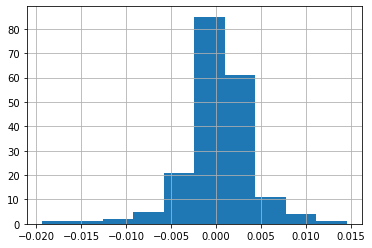

In [20]:
returns = equity.resample('1d').last().pct_change() 
bm_returns = test['close'].resample('1d').last().pct_change()
returns_ = returns - bm_returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(252)

Roll_Max = equity.resample('1d').last().cummax()
Daily_Drawdown = np.divide(equity, Roll_Max) - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Sharpe Ratio': sr,
    'CAGR': (equity[-1] / equity[0]) ** (365 / period) - 1,
    'Max Daily Drawdown': -Max_Daily_Drawdown.min(),
}))

equity.resample('1h').last().pct_change().hist()